In [1]:
#Set up the environment
library(reshape2)
library(tidyverse)
library(janitor) #has the rownames_to_column function
library(ggrepel)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




In [2]:
#Load in the chronos data
setwd("../data")
ccle.chronos = read.table("22q1_crispr_gene_effect.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1)) %>%
rename("sample" = 1)

In [3]:
#Load in the gene block matrix that lists the ancestry for all genes and for all cell lines
setwd("../data")
gene.block.matrix = read.table("gene.block.matrix.txt", sep = "\t", header = T)
row.names(gene.block.matrix) = NULL

#Format gene.block.matrix so that it is ready for our analysis
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample))

In [5]:
#Filter both datasets so that they share a common set of samples
intersecting.samples = intersect(ccle.chronos$sample, formatted.gene.block.matrix$sample)
intersecting.genes = intersect(colnames(ccle.chronos), colnames(formatted.gene.block.matrix))

#For 22q1
final.chronos.22q1 = ccle.chronos %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

#Assemble the final gene block matrix
final.gene.block = formatted.gene.block.matrix %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

In [7]:
#Load in the sample annotation data
setwd("../data")
sample.annotation = read.table('depmap_cell_lineage.csv', sep = ",", header = T) %>%
rename("sample" = 1)

In [8]:
#Calculate p-values and mean differences for 22q1

gene.names = colnames(final.gene.block)[2:ncol(final.gene.block)]


afr.lm.pval.vector = NULL
amr.lm.pval.vector = NULL
eas.lm.pval.vector = NULL
eur.lm.pval.vector = NULL
sas.lm.pval.vector = NULL
afr.mean.dif = NULL
amr.mean.dif = NULL
eas.mean.dif = NULL
eur.mean.dif = NULL
sas.mean.dif = NULL
for(gene in gene.names){
    
    #Filter the chronos data so that it only includes the gene we are interested in 
    chronos.filtered = final.chronos.22q1 %>% select(sample, all_of(gene))
    
    #Filter the gene block data so that it only includes the gene we are interested in
    gene.block.filtered = final.gene.block %>% select(sample, all_of(gene)) %>% rename("gene.symbol" = 2)
    
    #For each gene in the loop, figure out which cell lines have the version of that gene for each ancestry group
    afr.lines = gene.block.filtered %>% filter(gene.symbol %in% "0") %>% pull(sample)
    non.afr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "0") %>% pull(sample)
    amr.lines = gene.block.filtered %>% filter(gene.symbol %in% "1") %>% pull(sample)
    non.amr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "1") %>% pull(sample)
    eas.lines = gene.block.filtered %>% filter(gene.symbol %in% "2") %>% pull(sample)
    non.eas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "2") %>% pull(sample)
    eur.lines = gene.block.filtered %>% filter(gene.symbol %in% "3") %>% pull(sample)
    non.eur.lines = gene.block.filtered %>% filter(!gene.symbol %in% "3") %>% pull(sample)
    sas.lines = gene.block.filtered %>% filter(gene.symbol %in% "4") %>% pull(sample)
    non.sas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "4") %>% pull(sample)
    
    
    #Now get vectors of chronos scores for each ancestry group
    afr.chronos = chronos.filtered %>% filter(sample %in% afr.lines) %>% pull(2)
    non.afr.chronos = chronos.filtered %>% filter(sample %in% non.afr.lines) %>% pull(2)
    
    amr.chronos = chronos.filtered %>% filter(sample %in% amr.lines) %>% pull(2)
    non.amr.chronos = chronos.filtered %>% filter(sample %in% non.amr.lines) %>% pull(2)
    
    eas.chronos = chronos.filtered %>% filter(sample %in% eas.lines) %>% pull(2)
    non.eas.chronos = chronos.filtered %>% filter(sample %in% non.eas.lines) %>% pull(2)
    
    eur.chronos = chronos.filtered %>% filter(sample %in% eur.lines) %>% pull(2)
    non.eur.chronos = chronos.filtered %>% filter(sample %in% non.eur.lines) %>% pull(2)
    
    sas.chronos = chronos.filtered %>% filter(sample %in% sas.lines) %>% pull(2)
    non.sas.chronos = chronos.filtered %>% filter(sample %in% non.sas.lines) %>% pull(2)
    
    
    #Assemble data frames for performing the linear regression
    afr.df = c(afr.lines, non.afr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(afr.lines)), rep(1, length(non.afr.lines)))) %>%
    mutate("chronos_score" = c(afr.chronos, non.afr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    amr.df = c(amr.lines, non.amr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(amr.lines)), rep(1, length(non.amr.lines)))) %>%
    mutate("chronos_score" = c(amr.chronos, non.amr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eas.df = c(eas.lines, non.eas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eas.lines)), rep(1, length(non.eas.lines)))) %>%
    mutate("chronos_score" = c(eas.chronos, non.eas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eur.df = c(eur.lines, non.eur.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eur.lines)), rep(1, length(non.eur.lines)))) %>%
    mutate("chronos_score" = c(eur.chronos, non.eur.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    sas.df = c(sas.lines, non.sas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(sas.lines)), rep(1, length(non.sas.lines)))) %>%
    mutate("chronos_score" = c(sas.chronos, non.sas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    
    #Now calculate the p-values for each comparison (if there are more than three observations)
    if(length(afr.chronos) >= 3 & length(non.afr.chronos) >= 3){
        afr.pval = lm(chronos_score ~ ancestry_class + covariate, data = afr.df) %>% summary() %>% .[[4]] %>% .[2,4]
    } else { afr.pval = 1 }
    
      if(length(amr.chronos) >= 3 & length(non.amr.chronos) >= 3){
        amr.pval = lm(chronos_score ~ ancestry_class + covariate, data = amr.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { amr.pval = 1 }
    
      if(length(eas.chronos) >= 3 & length(non.eas.chronos) >= 3){
        eas.pval = lm(chronos_score ~ ancestry_class + covariate, data = eas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eas.pval = 1 }
    
      if(length(eur.chronos) >= 3 & length(non.eur.chronos) >= 3){
        eur.pval = lm(chronos_score ~ ancestry_class + covariate, data = eur.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eur.pval = 1 }
    
      if(length(sas.chronos) >= 3 & length(non.sas.chronos) >= 3){
        sas.pval = lm(chronos_score ~ ancestry_class + covariate, data = sas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { sas.pval = 1 }
    
    
    #Add the p-values to the vector outside of the loop
    afr.lm.pval.vector = c(afr.lm.pval.vector, afr.pval)
    amr.lm.pval.vector = c(amr.lm.pval.vector, amr.pval)
    eas.lm.pval.vector = c(eas.lm.pval.vector, eas.pval)
    eur.lm.pval.vector = c(eur.lm.pval.vector, eur.pval)
    sas.lm.pval.vector = c(sas.lm.pval.vector, sas.pval)
    
    
    #Calculate the differences in means
    afr.dif = mean(afr.chronos) - mean(non.afr.chronos)
    amr.dif = mean(amr.chronos) - mean(non.amr.chronos)
    eas.dif = mean(eas.chronos) - mean(non.eas.chronos)
    eur.dif = mean(eur.chronos) - mean(non.eur.chronos)
    sas.dif = mean(sas.chronos) - mean(non.sas.chronos)
    
    #Add the mean differences to the vectors
    afr.mean.dif = c(afr.mean.dif, afr.dif)
    amr.mean.dif = c(amr.mean.dif, amr.dif)
    eas.mean.dif = c(eas.mean.dif, eas.dif)
    eur.mean.dif = c(eur.mean.dif, eur.dif)
    sas.mean.dif = c(sas.mean.dif, sas.dif)
}

In [9]:
#Construct a dataset with all of this information
lm.pval.df = cbind(afr.lm.pval.vector, amr.lm.pval.vector, eas.lm.pval.vector, eur.lm.pval.vector, sas.lm.pval.vector, afr.mean.dif, amr.mean.dif, eas.mean.dif, eur.mean.dif, sas.mean.dif) %>%
data.frame() %>%
mutate("gene" = gene.names, .before = 1) %>%
mutate("afr_fdr" = p.adjust(afr.lm.pval.vector, method = "BH", n = length(afr.lm.pval.vector))) %>%
mutate("amr_fdr" = p.adjust(amr.lm.pval.vector, method = "BH", n = length(amr.lm.pval.vector))) %>%
mutate("eas_fdr" = p.adjust(eas.lm.pval.vector, method = "BH", n = length(eas.lm.pval.vector))) %>%
mutate("eur_fdr" = p.adjust(eur.lm.pval.vector, method = "BH", n = length(eur.lm.pval.vector))) %>%
mutate("sas_fdr" = p.adjust(sas.lm.pval.vector, method = "BH", n = length(sas.lm.pval.vector)))

In [10]:
#Write dataset
setwd("../data")
write.table(lm.pval.df, "lm_ancestry_associated_dependency_pvals.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [11]:
#Make a data frame that we can use for creating the volcano plot
differential.df = lm.pval.df %>%
select(gene, afr.mean.dif, amr.mean.dif, eas.mean.dif, eur.mean.dif, sas.mean.dif) %>%
melt(id = "gene") %>%
rename("ancestry" = 2, "differential" = 3) %>%
mutate(ancestry = gsub("\\..*", "", ancestry)) %>%
mutate("flag" = paste(gene, ancestry, sep = "_"))

fdr.df = lm.pval.df %>%
select(gene, "afr_fdr", "amr_fdr", "eas_fdr", "eur_fdr", "sas_fdr") %>%
melt(id = "gene") %>%
rename("ancestry" = 2, "fdr" = 3) %>%
mutate(ancestry = gsub("_..*", "", ancestry)) %>%
mutate("flag" = paste(gene, ancestry, sep = "_"))


#Merge the fdr and the differential data together
merged.df.for.volcano.plot = inner_join(differential.df, fdr.df, by = "flag") %>%
select(-ancestry.x, -gene.y) %>%
rename("gene" = 1, "ancestry" = 4)

head(merged.df.for.volcano.plot)

,gene,differential,flag,ancestry,fdr
,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,A1BG,0.018967685,A1BG_afr,afr,0.998556
2,A1CF,-0.035117475,A1CF_afr,afr,0.998556
3,A2M,-0.010031350,A2M_afr,afr,0.998556
4,A2ML1,0.009988105,A2ML1_afr,afr,0.998556
5,A3GALT2,0.003320528,A3GALT2_afr,afr,0.998556
6,A4GALT,0.004528391,A4GALT_afr,afr,0.998556


Warning message:
“Removed 119 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 119 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“Removed 119 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 119 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


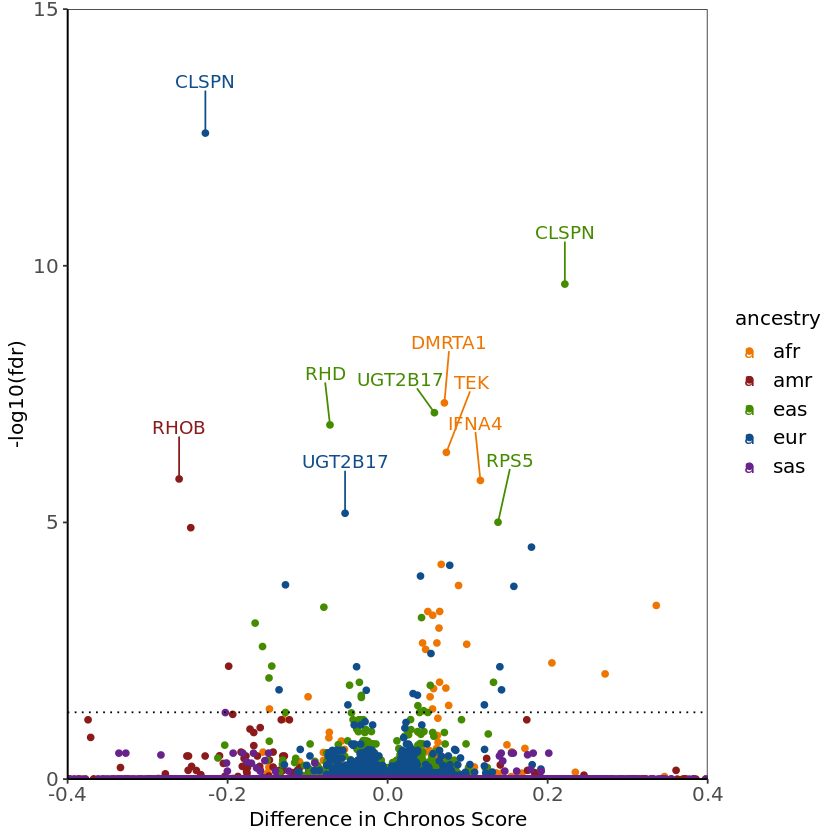

In [12]:
#Create the color vector
group.colors <- c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")

#Now finally plot the volcano plot
merged.df.for.volcano.plot %>%
ggplot(aes(x = differential, y = -log10(fdr), color = ancestry)) +
geom_point(aes(x = differential, y = -log10(fdr), color = ancestry)) +
geom_hline(linetype = "dotted", yintercept = 1.301) +

theme_bw() +
scale_colour_manual(values = group.colors) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("-log10(fdr)") +
xlab("Difference in Chronos Score") +
labs(fill='Ancestry Group') +
scale_y_continuous(expand = c(0,0), limits = c(0, 15)) +
scale_x_continuous(expand = c(0,0), limits = c(-0.4, 0.4)) +

geom_text_repel(
aes(label=ifelse(-log10(fdr) > 5, 
as.character(gene),'')), 
box.padding = 0.5,
nudge_y = 1,
segment.ncp = 3,
segment.angle = 20)

#Export the figure
setwd("../output")
ggsave("figure_1d.pdf", width = 4, height = 3)